# Import

In [78]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [79]:
# Załadowanie danych
data = pd.read_csv('realdonaldtrump.csv')
dataOriginal = data.copy()

# Usunięcie url z treści
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',content)

# Usunięcie linków twittera do zdjęć
def remove_pic(content):
	pic = re.compile(r'pic.twitter.com/\S+')
	return pic.sub(r'',content)

# Usunięcie mentionów
def remove_ment(content):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    content = mention1.sub(r'',content)
    return mention2.sub(r'',content)

# Usunięcie znaków interpunkcyjnych
def remove_punct(content):
    table = str.maketrans('', '', string.punctuation)
    return content.translate(table)

# Usunięcie html
def remove_html(content):
    html=re.compile(r'<.*?>')
    return html.sub(r'',content)

# Usunięcie emotikonów
def remove_emoji(content):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', content)

# Dekontrakcja
def decontraction(content):
    content = re.sub(r"won\'t", " will not", content)
    content = re.sub(r"won\'t've", " will not have", content)
    content = re.sub(r"can\'t", " can not", content)
    content = re.sub(r"don\'t", " do not", content)
    content = re.sub(r"can\'t've", " can not have", content)
    content = re.sub(r"ma\'am", " madam", content)
    content = re.sub(r"let\'s", " let us", content)
    content = re.sub(r"ain\'t", " am not", content)
    content = re.sub(r"shan\'t", " shall not", content)
    content = re.sub(r"sha\n't", " shall not", content)
    content = re.sub(r"o\'clock", " of the clock", content)
    content = re.sub(r"y\'all", " you all", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"n\'t've", " not have", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'d've", " would have", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ll've", " will have", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    content = re.sub(r"\'re", " are", content)
    return content

# Separacja słów od liczb
def seperate_alphanumeric(content):
    words = content
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# Znalezienie powtarzających się znaków
def cont_rep_char(content):
    tchr = content.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

# Usunięcie powtarzających się znaków
def unique_char(rep, content):
    substitute = re.sub(r'(\w)\1+', rep, content)
    return substitute

# Usunięcie stop words
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

# Stemming
def stem(text):
    tokens = []
    for token in text.split():
        tokens.append(stemmer.stem(token))
    return " ".join(tokens)

# Ustawienie wszystkich liter na małe
data['content'] = data['content'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
data['content'] = data['content'].apply(lambda x : remove_pic(x))
data['content'] = data['content'].apply(lambda x : remove_url(x))
data['content'] = data['content'].apply(lambda x : remove_ment(x))
data['content'] = data['content'].apply(lambda x : remove_punct(x))
data['content'] = data['content'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
data['content'] = data['content'].apply(lambda x : decontraction(x))
data['content'] = data['content'].apply(lambda x : seperate_alphanumeric(x))
data['content'] = data['content'].apply(lambda x : unique_char(cont_rep_char,x))
data['content'] = data['content'].apply(lambda x : remove_stopwords(x))
#data['content'] = data['content'].apply(lambda x : stem(x))

# Usunięcie duplikatów
data = data.drop_duplicates(subset=['content'])

# Usunięcie pustych wartości
data = data.dropna(subset=['content'])

# Usunięcie zbędnych kolumn
data = data.drop(['link','mentions','hashtags', 'retweets', 'favorites', 'date'], axis=1)

# NLP model

In [80]:
# Utworenie modelu
sia = SentimentIntensityAnalyzer()

# Obliczenie sentymentu
def compute_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

# Obliczenie sentymentu dla każdego tweeta
dataSentiment = data.copy()
dataSentiment['compound'], dataSentiment['negative'], dataSentiment['neutral'], dataSentiment['positive'] = zip(*data['content'].apply(compute_sentiment))

# Kategoryzacja sentymentu
def categorize_sentiment(compound):
    if compound <= -0.01:
        return 'negative'
    elif compound >= 0.01:
        return 'positive'
    else:
        return 'neutral'
dataSentiment['sentiment'] = dataSentiment['compound'].apply(categorize_sentiment)

# Prezentacja danych
pd.set_option('display.max_colwidth', None)
dataSentiment.sample(5)

,id,content,compound,negative,neutral,positive,sentiment
15700,477395098712281088,ill say likely republican could realistically beat hillary 2016 please consider running,-0.1280,0.185,0.662,0.152,negative
27290,686252152042336256,yesterday iowa amazing two speeches front two great sold crowds love candidate selffunding,0.9201,0.000,0.452,0.548,positive
16921,502559967338303490,saw nyc trump buildings past wknd amazing cant wait go back n see great thanks,0.8957,0.000,0.505,0.495,positive
30396,783660227530862592,constant interruptions last night tim kaine allowed mike pence big,-0.4019,0.231,0.769,0.000,negative
14526,450654847222960128,love see one one bill maher without morons audience would chance,0.7999,0.000,0.495,0.505,positive


# Data presentation

In [81]:
# Przykładowe dane
pd.set_option('display.max_colwidth', None)
data.sample(5)

,id,content
34597,1012297599431401474,amy kremer women trump great brave smart thank amy
4392,265924424623075328,federal gov handled sandy worse katrina excuse people dont electricity fuel yet
1922,197398394472382464,bad move released 147 aid palestinians money going hamas
37136,1114135285510676480,trolling mueller report democrats lost collusion inventing coverup james freeman
11588,375600452882423808,seen video rebel commander cutting eating syrian soldiers heart liver


Number of positive tweets: 23629


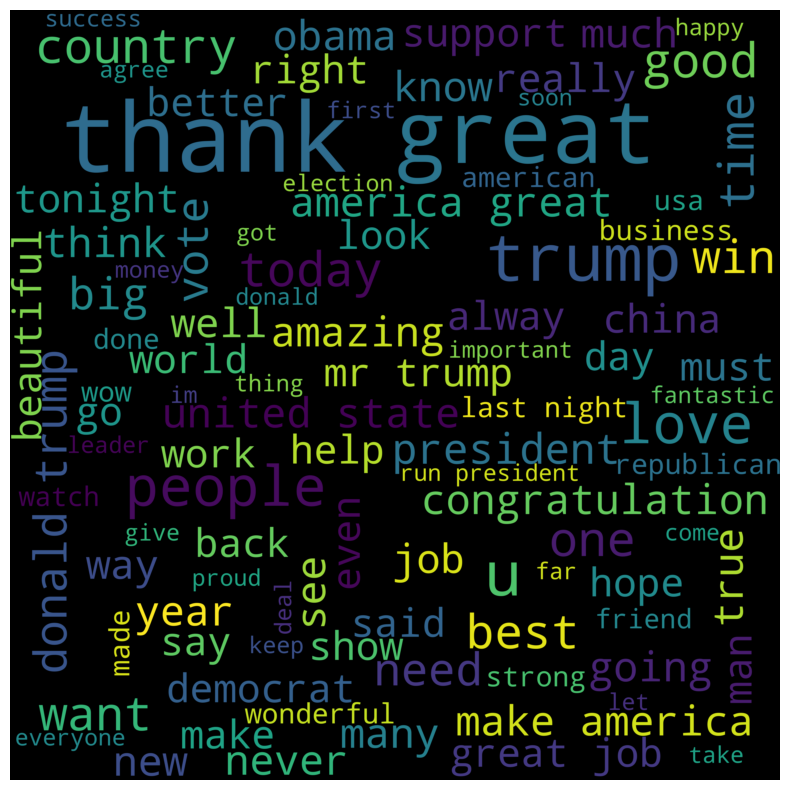

Number of negative tweets: 10473


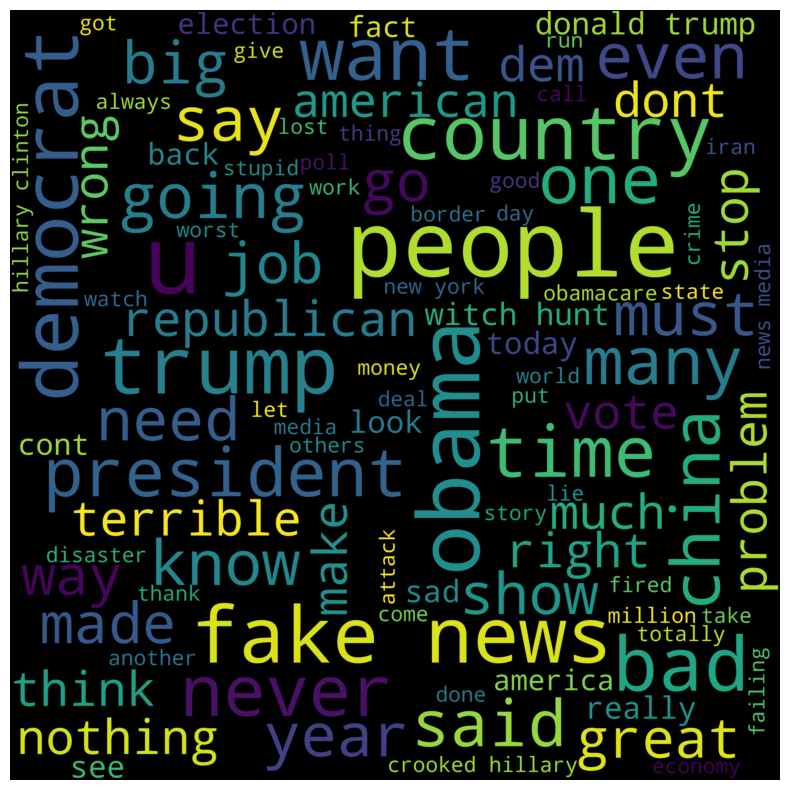

Number of neutral tweets: 6204


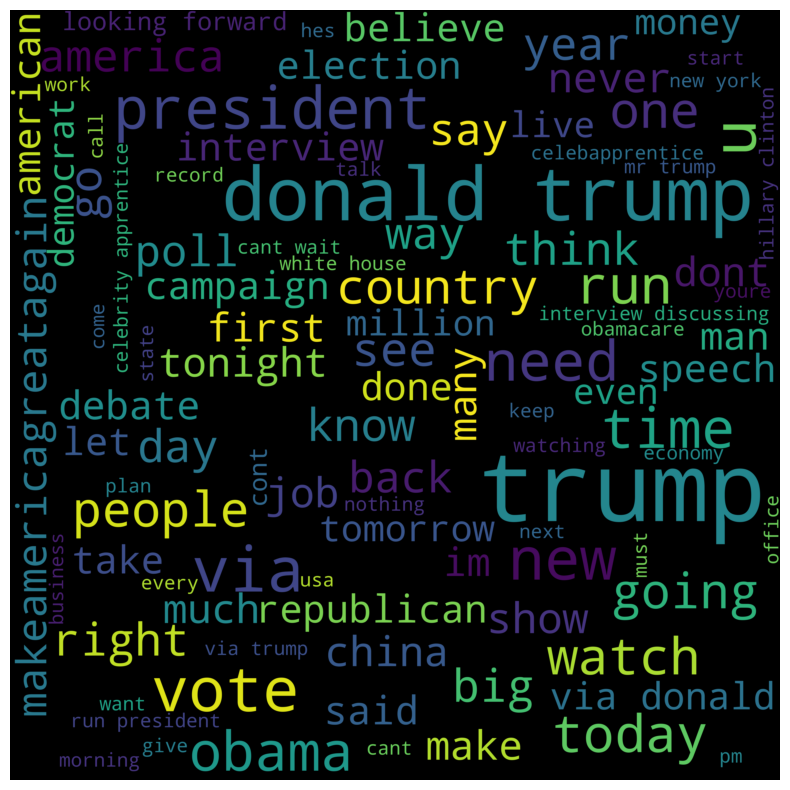

In [82]:
# Prezentacja najczęściej występujących słów w kategoriach sentymentu
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_data = dataSentiment[dataSentiment['sentiment'] == sentiment]
    print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
    word_cloud_text = ' '.join(sentiment_data['content'] )
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# SHAP analysis

In [83]:
# Przygotowanie danych do modelu
X = dataSentiment[[ 'negative', 'neutral', 'positive']]
y = dataSentiment['sentiment']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trening modelu Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Trening modelu Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Trening modelu SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred_rf = rf_model.predict(X_test)

# Predykcje na zbiorze testowym
y_pred_gb = gb_model.predict(X_test)

# Predykcje na zbiorze testowym
y_pred_svm = svm_model.predict(X_test)

# Raport klasyfikacji
print("Random Forest")
print(classification_report(y_test, y_pred_rf))

# Raport klasyfikacji
print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))

# Raport klasyfikacji
print("SVM")
print(classification_report(y_test, y_pred_svm))

Random Forest
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2106
     neutral       0.99      0.99      0.99      1296
    positive       0.99      0.99      0.99      4660

    accuracy                           0.99      8062
   macro avg       0.99      0.99      0.99      8062
weighted avg       0.99      0.99      0.99      8062

Gradient Boosting
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2106
     neutral       1.00      0.98      0.99      1296
    positive       0.99      0.99      0.99      4660

    accuracy                           0.99      8062
   macro avg       0.99      0.99      0.99      8062
weighted avg       0.99      0.99      0.99      8062

SVM
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2106
     neutral       1.00      0.98      0.99      1296
    positive       0.99      0.99      

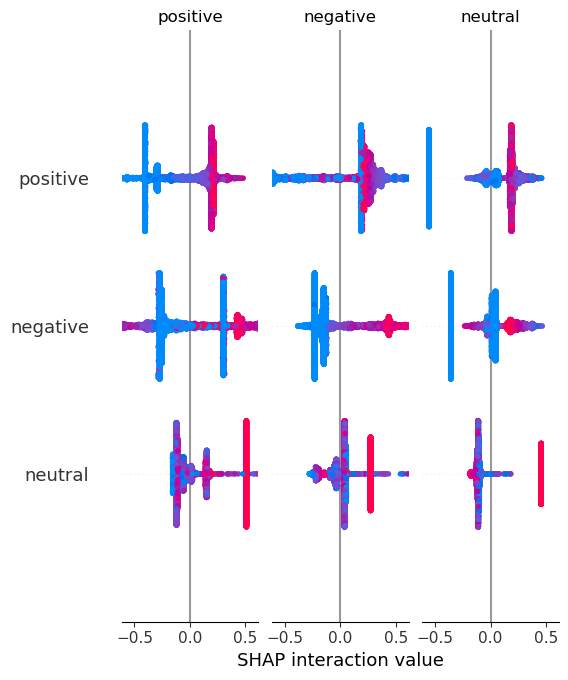

   number          id  \
0       1  1698308935   
1       2  1701461182   
2       3  1737479987   
3       4  1741160716   
4       5  1773561338   

                                                                                                  content  
0                   sure tune watch donald trump late night david letterman presents top ten list tonight  
1  donald trump appearing view tomorrow morning discuss celebrity apprentice new book think like champion  
2                               donald trump reads top ten financial tips late show david letterman funny  
3                                     new blog post celebrity apprentice finale lessons learned along way  
4                                        persona never wallflower rather build walls cling donald j trump  


In [85]:
# Analiza SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji
shap.summary_plot(shap_values, X_test)

# Zapisanie wyników do nowego pliku CSV
data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
df = data[['number'] + list(data.columns[:-1])]
df.to_csv('tweets_sentiment_with_model.csv', index=False)
print(df.head())

# Conclusions